# Overview

Let's fix the saturated tanh issue of our training process.

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from torch.utils.tensorboard import SummaryWriter


# read in all the words
with open('/kaggle/input/character-lm-without-framework/names.txt', 'r', encoding='utf-8') as f:
    words=f.read()

words=words.splitlines()

# build the vocabulary of characters and 
chars=sorted(list(set(''.join(words))))

stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)


block_size=3 # context length: how many characters do we take to predict the next one?


def build_dataset(words):
    X,Y=[],[]
    
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix] # crop and append
            
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr, Ytr=build_dataset(words[:n1])     # 80%
Xdev, Ydev=build_dataset(words[n1:n2]) # 10%
Xte, Yte=build_dataset(words[n2:])     # 10%


# MLP

n_embd=10 # the dimensionality of the character embedding vectors
n_hidden=200 # the number of neurons in the hidden layer of the MLP
max_steps=200000
batch_size=32
lossi=[]
writer=SummaryWriter()

g=torch.Generator().manual_seed(2147483647) # for reproducibility
C=torch.randn((vocab_size, n_embd),           generator=g)
W1=torch.randn((n_embd*block_size, n_hidden), generator=g)
b1=torch.randn(n_hidden,                      generator=g)
W2=torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2=torch.randn(vocab_size,                    generator=g) * 0

parameters=[C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad=True
    

for i in range(max_steps):
    # minibatch construct
    ix=torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb=Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb=C[Xb] # embed the characters into vectors
    embcat=emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@W1+b1 # hidden layer pre-activation
    
    # If all of these outputs h are in the flat regions of -1 and 1, 
    # then the gradients that are flowing through the network will just get
    # destroyed at this layer.
    h=torch.tanh(hpreact) # hidden layer

    logits=h@W2+b2 # output layer
    loss=F.cross_entropy(logits, Yb) # loss function
    writer.add_scalar("Loss/train", loss, i)
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.1 if i< 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data+=-lr*p.grad
    
    # track stats
    if i%10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

writer.flush()
writer.close()

2024-07-29 02:09:15.731955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 02:09:15.732100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 02:09:15.915687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
11897
      0/ 200000: 3.3221


# What is the issue of tanh?

**THe deeper problem working inside the neural net. No matter what inputs you plug in from your dataset, the `tanh` neuron always fires completely $1$ or completely $-1$ and then it will just not learn, because al the gradients wil be just zeroed out.** 

And also, 
* `Sigmoid` will have the exact same issue, because it is a squashing neuron and so the same will be true for sigmoid.
* Same to `relu`, `relu` has a completely flat region here below zero. If the pass-through neuron is positive and it's pre-activation is negative. It will just shut it off since the region here is completely flat then during back propagation.
* ELU: it also has flat parts

**Note: For some of other neurons will not have this issue**
* leaky ReLU: it doesn't have flat tails. So, it almost always get gradients



Please see more detail in the section below.

The value of `h` the activations of hidden states. Let's investgate one step by one step. We can see the value of `h` below. It has many values are equal to `-1` or `1`.

## Why many times of -1 and 1 does matter?

`tanh` function is a squashing functon it takes arbitrary numbers and it squashes them into a range of negative one and one, and it does so smoothly.

In [2]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

## Visualization(histogram) of h

Let's look at the histogram of h to get the better idea of the distribution of the value inside this tensor.

In [3]:
# 32 example, 200 activations in each example
h.shape

torch.Size([32, 200])

(array([2069.,  144.,  106.,   82.,   59.,   56.,   44.,   30.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

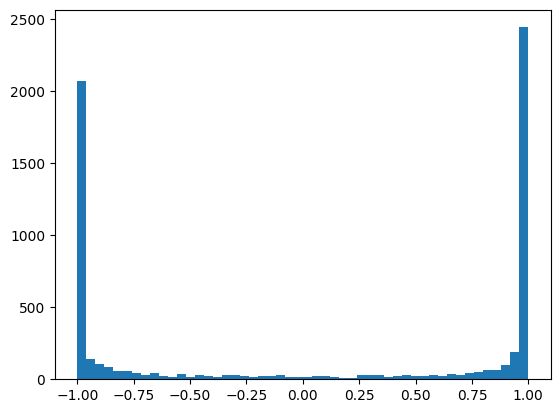

In [4]:
# we can view it as negative one to stretch
# it out into one large vector and we can then call to list to convert this into one large python list

# we visualize this tensor with plt.hist, and 50 bins
plt.hist(h.view(-1).tolist(),50)

# from this digram we can see that `tanh` is very very active 
# and the distribution of the pre-activations that feed into the tanh
# and we can see that the distribution of the pre-activations 
# are very very board take numbers between


# this isn't what we want. It means the neurouns are less trained.

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793571, -18.31571732, -17.57349892, -16.83128052,
        -16.08906212, -15.34684372, -14.60462532, -13.86240692,
        -13.12018852, -12.37797012, -11.63575172, -10.89353333,
        -10.15131493,  -9.40909653,  -8.66687813,  -7.92465973,
         -7.18244133,  -6.44022293,  -5.69800453,  -4.95578613,
         -4.21356773,  -3.47134933,  -2.72913094,  -1.98691254,
         -1.24469414,  -0.50247574,   0.23974266,   0.98196106,
          1.72417946,   2.46639786,   3.20861626,   3.95083466,
          4.69305305,   5.43527145,   6.17748985,   6.91970825,
          7.66192665,   8.40414505,   9.14636345,   9.88858185,
         10.630800

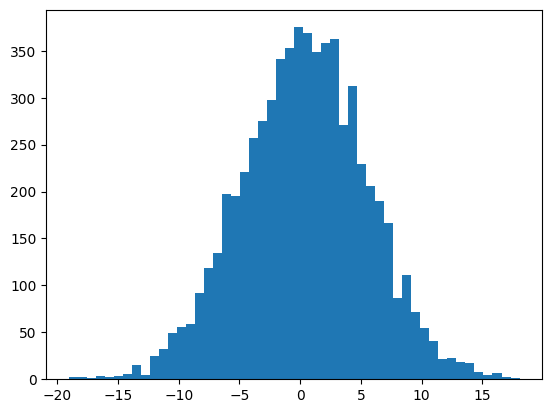

In [5]:
# Visualize the pre-activations

plt.hist(hpreact.view(-1).tolist(), 50)

## Remember how we implement tahn in backward

```
def tanh(self):
    x=self.data
    t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
    out=Value(t, (self,), 'tanh')
    
    def _backward():
        self.grad+=(1-t**2)*out.grad # chain rule with the local gradient
    out._backward=_backward

    return out
```

**We can see above, if $t=-1$ or $t=1$ the gradient will be killed.** If the output is very close to 1 then we are in the tail of tanh, and changing basically the input isn't going to impact the output of the 10th too much, because it's in a flat region of the 10th tanh. So, therefore there's no impact on the loss and so indeed the weights and the biases along with this tanh neuron don't impact the loss because the output of the standard unit is in the flat refion in the tanh.

So, the gradient would be basically zero and vanished.

**When `tanh` takes on the exactly value of zero, then the gradient is just passed through.** But more you are in the flat tails the more the gradient is squashed. So, we will see that the gradient flowing through `tanh` can only every decrease int he amount that it decreases is proportional through a square here depending on how far you are in the flat tails of this tanh.



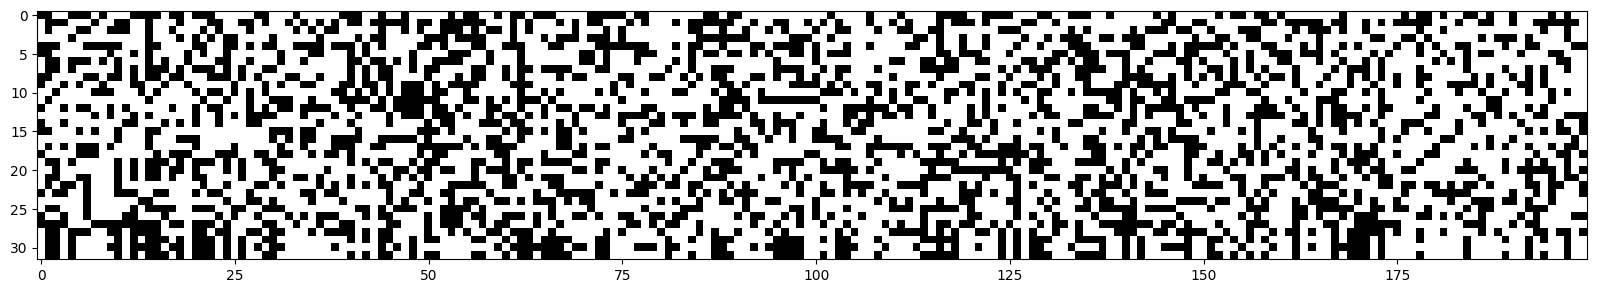

In [6]:
plt.figure(figsize=(20,10))
# we check how often of abs(h) in the flat region
# h.abs()>0.99 is a boolean tensor, white is True, Black is false
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

# here are have 32 examples and 200 hidden neurons.

# there are lots of whites tell us the tanh neurons were very very active
# they are in a flat tail

# So, in all these cases, the backward gradient would get destroyed

# If the entire colume is white, we call it a dead neuron which means the neuron will never learn
# it is a dead neuron. This could be a tanh neuron where the initialization of the weights and the biases
# could be such that no sinle example ever activates in this tanh.

# How to fix this?

According to above, we found our `hpreact` are less trained. We need to fix this.

## Where is the issue?

Please see below the `forward pass` of our model structure. The first two lines of code are uniform gaussian but then it's multiplied by $W1+B1$, and `hpreact` is too far off from zero and that's causing the issue so we want this reactivation to be closer to zero and that's causing the issue.

```python
# forward pass
emb=C[Xb] # embed the characters into vectors
embcat=emb.view(emb.shape[0], -1) # concatenate the vectors
hpreact=embcat@W1+b1 # hidden layer pre-activation
```

So, we want this reactivation to be closer to zero very similar to what we have with logits. And make sure there is no neurons that's saturated above 0.99 in either direction.

In [7]:
# MLP

n_embd=10 # the dimensionality of the character embedding vectors
n_hidden=200 # the number of neurons in the hidden layer of the MLP
max_steps=200000
batch_size=32
lossi=[]
writer=SummaryWriter()

g=torch.Generator().manual_seed(2147483647) # for reproducibility
C=torch.randn((vocab_size, n_embd),           generator=g)
W1=torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1=torch.randn(n_hidden,                      generator=g) * 0.01
W2=torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2=torch.randn(vocab_size,                    generator=g) * 0

parameters=[C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad=True
    

for i in range(max_steps):
    # minibatch construct
    ix=torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb=Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb=C[Xb] # embed the characters into vectors
    embcat=emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@W1+b1 # hidden layer pre-activation
    
    # If all of these outputs h are in the flat regions of -1 and 1, 
    # then the gradients that are flowing through the network will just get
    # destroyed at this layer.
    h=torch.tanh(hpreact) # hidden layer

    logits=h@W2+b2 # output layer
    loss=F.cross_entropy(logits, Yb) # loss function
    writer.add_scalar("Loss/train", loss, i)
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.1 if i< 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data+=-lr*p.grad
    
    # track stats
    if i%10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

writer.flush()
writer.close()

11897
      0/ 200000: 3.3135


(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

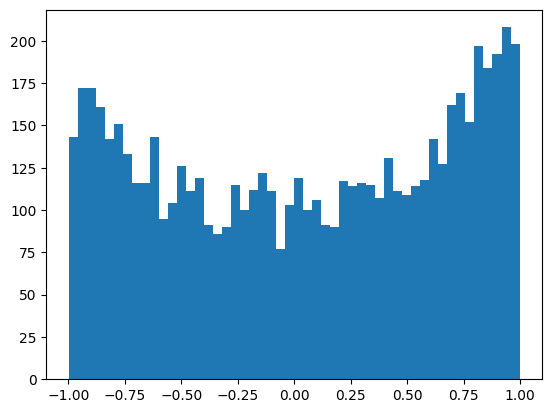

In [8]:
plt.hist(h.view(-1).tolist(),50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  40.,  77.,  63., 101., 127., 171., 184., 220., 227., 267.,
        312., 301., 356., 367., 376., 360., 370., 331., 298., 278., 292.,
        242., 191., 167., 137., 104.,  85.,  77.,  41.,  30.,  28.,  20.,
         11.,   7.,  11.,   5.,   2.,   7.]),
 array([-3.76367092, -3.62009715, -3.47652338, -3.33294961, -3.18937584,
        -3.04580207, -2.9022283 , -2.75865453, -2.61508076, -2.47150699,
        -2.32793322, -2.18435945, -2.04078568, -1.8972119 , -1.75363813,
        -1.61006436, -1.46649059, -1.32291682, -1.17934305, -1.03576928,
        -0.89219551, -0.74862174, -0.60504797, -0.4614742 , -0.31790043,
        -0.17432666, -0.03075289,  0.11282088,  0.25639465,  0.39996842,
         0.54354219,  0.68711596,  0.83068974,  0.97426351,  1.11783728,
         1.26141105,  1.40498482,  1.54855859,  1.69213236,  1.83570613,
         1.9792799 ,  2.12285367,  2.26642744,  2.41000121,  2.55357498,
 

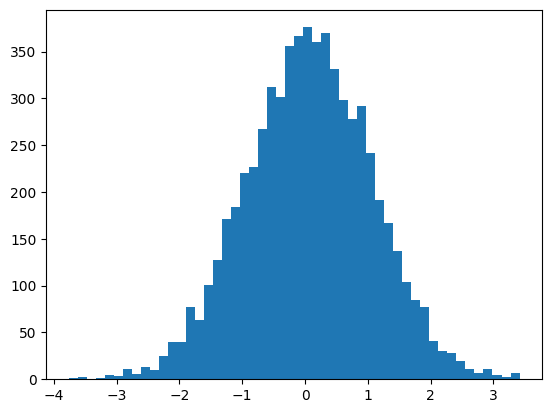

In [9]:
plt.hist(hpreact.view(-1).tolist(), 50)

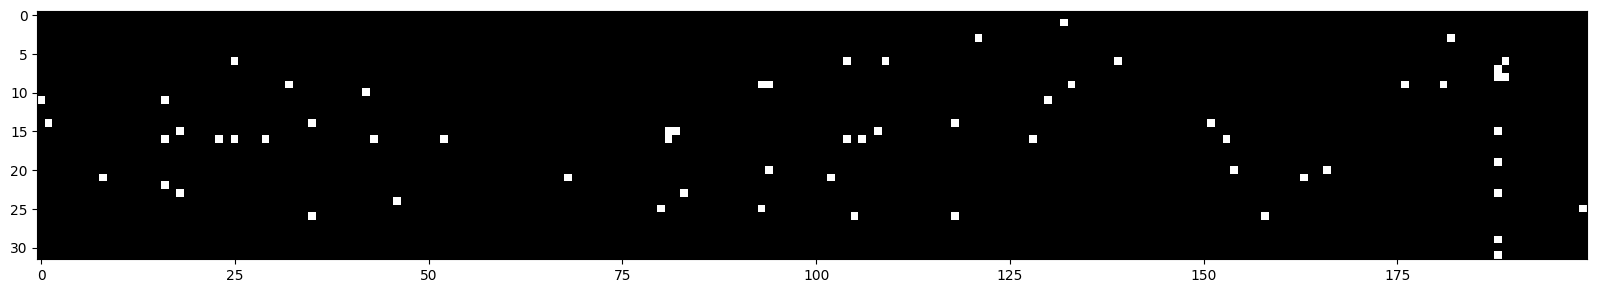

In [10]:
plt.figure(figsize=(20,10))
# we check how often of abs(h) in the flat region
# h.abs()>0.99 is a boolean tensor, white is True, Black is false
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

# Let's finish the entire training process



In [11]:
# MLP

n_embd=10 # the dimensionality of the character embedding vectors
n_hidden=200 # the number of neurons in the hidden layer of the MLP
max_steps=200000
batch_size=32
lossi=[]
writer=SummaryWriter()

g=torch.Generator().manual_seed(2147483647) # for reproducibility
C=torch.randn((vocab_size, n_embd),           generator=g)
W1=torch.randn((n_embd*block_size, n_hidden), generator=g) * 0.2
b1=torch.randn(n_hidden,                      generator=g) * 0.01
W2=torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2=torch.randn(vocab_size,                    generator=g) * 0

parameters=[C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad=True
    

for i in range(max_steps):
    # minibatch construct
    ix=torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb=Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb=C[Xb] # embed the characters into vectors
    embcat=emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@W1+b1 # hidden layer pre-activation
    
    # If all of these outputs h are in the flat regions of -1 and 1, 
    # then the gradients that are flowing through the network will just get
    # destroyed at this layer.
    h=torch.tanh(hpreact) # hidden layer

    logits=h@W2+b2 # output layer
    loss=F.cross_entropy(logits, Yb) # loss function
    writer.add_scalar("Loss/train", loss, i)
    
    # backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.1 if i< 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data+=-lr*p.grad
    
    # track stats
    if i%10000 ==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

writer.flush()
writer.close()

11897
      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


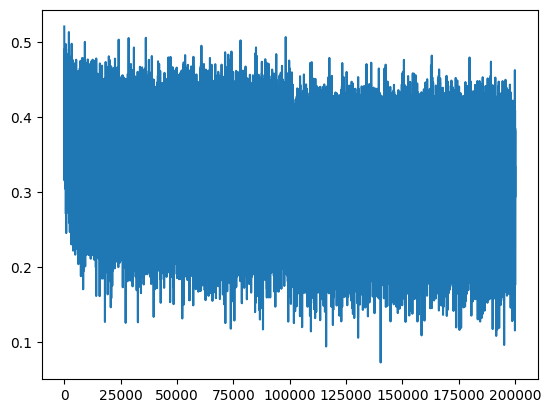

In [12]:
plt.plot(lossi)

In [13]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb=C[x] # (N, block_size, n_embd)
    embcat=emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h=torch.tanh(embcat @W1+b1) # (N, n_hidden)
    logits=h@W2+b2 #(N, vocab_size)
    loss=F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


# Sample from our model

In [14]:
g=torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out=[]
    context=[0]*block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb=C[torch.tensor([context])] # (1, block_size, n_embd)
        h=torch.tanh(emb.view(1,-1) @ W1+b1)
        logits=h@W2+b2
        probs=F.softmax(logits, dim=1)
        # sample from the distribution
        ix=torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out)) # decode the print and the generated word

mora.
mayah.
see.
mad.
ryll.
renvestendraegusteredielin.
shi.
jen.
edeiseananar.
kayzion.
kamin.
shubergianaiya.
kinde.
jennex.
teron.
ububynder.
yarue.
els.
kayshaykella.
hal.


# Conclusion

We can see we get better result with a better initialization.

# Acknowledgement

* https://www.youtube.com/watch?v=P6sfmUTpUmc&t=41s
* https://www.kaggle.com/code/aisuko/character-lm-without-framework/notebook